In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
import requests as req
import json
import multiprocessing as mp


from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

new_path = os.getcwd().replace('/notebooks', '')
print(f'Adding {new_path} to sys.path')

if new_path not in sys.path:
    sys.path.append(new_path)

# Local imports
from curvemetrics.src.classes.datahandler import DataHandler
from curvemetrics.src.classes.datafetcher import DataFetcher
from curvemetrics.src.classes.metricsprocessor import MetricsProcessor
from curvemetrics.src.plotting.plot import bocd_plot_comp
from curvemetrics.src.classes.model import BOCD

Adding /root/curve-lp-metrics to sys.path


In [3]:
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 10})

In [65]:
datahandler = DataHandler()
token_metadata = datahandler.get_token_metadata()
pool_metadata = datahandler.get_pool_metadata()

pool = "0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7" 

start_ts, start_block = DataFetcher.get_block(datetime.fromisoformat("2023-01-01"))
end_ts, end_block = DataFetcher.get_block(datetime.fromisoformat("2023-05-01"))

In [69]:
# swaps_data = datahandler.get_swaps_data(pool, start_ts, end_ts)
# lp_data = datahandler.get_lp_data(pool, start_ts, end_ts)
# pool_data = datahandler.get_pool_data(pool, start_ts, end_ts)
shannon = datahandler.get_pool_metric(pool, 'shannonsEntropy', start_ts, end_ts)
# snapshots = datahandler.get_pool_snapshots(pool, start_ts, end_ts)
lp_share_price = datahandler.get_pool_metric(pool, 'lpSharePrice', start_ts, end_ts)
y = datahandler.get_changepoints(pool, 'baseline', 'baseline', start_ts, end_ts)

# ohlcvs = {}
# for token in set(swaps_data['tokenBought']):
#     ohlcv = datahandler.get_ohlcv_data(token, start=start_ts, end=end_ts)
#     if token == "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2":
#         token = "0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee"
#     ohlcvs[token] = ohlcv

In [118]:
y

timestamp
2023-01-19 04:01:00    1674100860
2023-02-03 21:52:00    1675461120
2023-03-11 04:31:00    1678509060
2023-03-11 04:36:00    1678509360
2023-03-11 04:45:00    1678509900
2023-03-11 05:48:00    1678513680
2023-03-11 05:58:00    1678514280
2023-03-11 07:04:00    1678518240
2023-03-11 17:32:00    1678555920
2023-03-11 17:53:00    1678557180
2023-03-11 18:18:00    1678558680
2023-03-12 08:05:00    1678608300
2023-03-12 08:08:00    1678608480
2023-03-12 08:13:00    1678608780
2023-03-12 08:17:00    1678609020
2023-03-12 08:20:00    1678609200
2023-03-12 08:33:00    1678609980
Name: changepoints, dtype: int64

<Axes: xlabel='timestamp'>

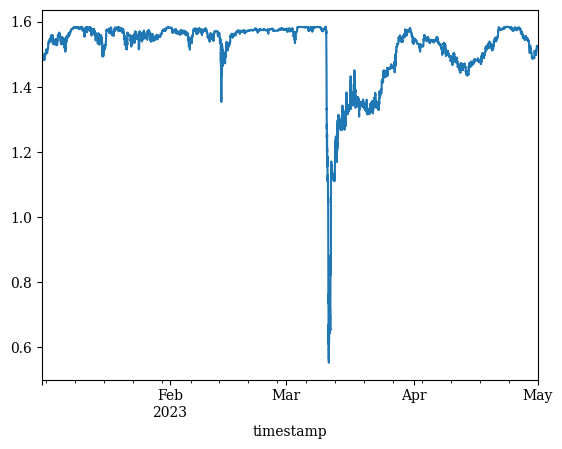

In [68]:
shannon.plot()

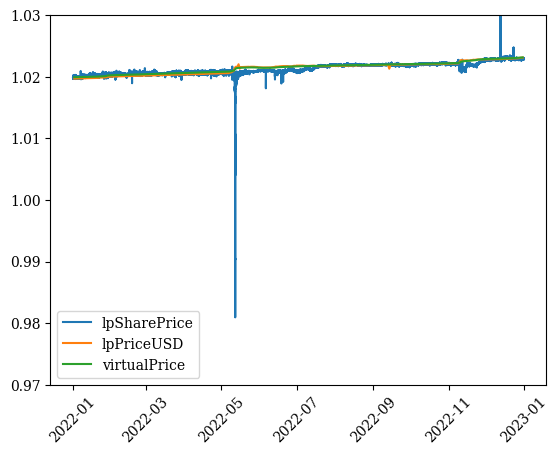

In [29]:
f, ax = plt.subplots()

ax.plot(lp_share_price.loc['2022'].index, lp_share_price.loc['2022'], label='lpSharePrice')
ax.plot(snapshots.loc['2022'].index, snapshots.loc['2022']['lpPriceUSD'], label='lpPriceUSD')
ax.plot(snapshots.loc['2022'].index, snapshots.loc['2022']['virtualPrice']/10**18, label='virtualPrice')
ax.set_ylim(0.97, 1.03)
ax.tick_params(axis='x', rotation=45)
ax.legend()

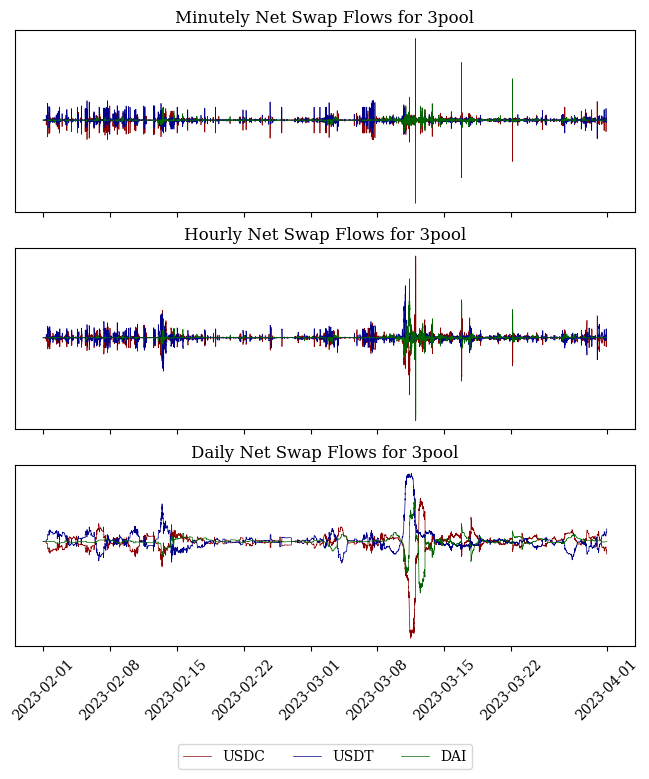

In [87]:
f, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

titles = ['Minutely', 'Hourly', 'Daily']
freqs = ['1min', '1h', '1d']

for i, ax in enumerate(axs):

    usdc_flow = pool_metrics['USDC.netSwapFlow'].rolling(freqs[i]).sum() / 1e6
    usdt_flow = pool_metrics['USDT.netSwapFlow'].rolling(freqs[i]).sum() / 1e6
    dai_flow = pool_metrics['DAI.netSwapFlow'].rolling(freqs[i]).sum() / 1e6

    ax.plot(usdc_flow.index, usdc_flow, label='USDC', linewidth=0.5, c='darkred')
    ax.plot(usdt_flow.index, usdt_flow, label='USDT', linewidth=0.5, c='darkblue')
    ax.plot(dai_flow.index, dai_flow, label='DAI', linewidth=0.5, c='darkgreen')

    # ax.grid(True)
    ax.set_title(f'{titles[i]} Net Swap Flows for 3pool')
    ax.set_yticks([])
    
ax.tick_params(axis='x', rotation=45)
axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=3)
f.savefig('../figs/3pool_swap_flows.png', bbox_inches='tight')

# Grid Search

In [71]:
# alpha = [10**i for i in range(1, 5)]
# beta = [10**i for i in range(-5, -1)]
# kappa = [10**i for i in range(-5, -1)]

alpha = [10000]
beta = [1e-5]
kappa = [0.01]

grid = [[a, b, k] for a in alpha for b in beta for k in kappa]
print(len(grid))

1


In [92]:
freq = '1h'
X = np.log1p(shannon.pct_change()).dropna().resample(freq).mean()
port = lp_share_price.resample(freq).mean()

bocd = BOCD()
results = bocd.tune(grid, X, y.index)


Finished tuning hyperparameters

Results: {(10000, 1e-05, 0.01): (0.16666666666666666, 0.03926701570680628, 0.8823529411764706)}
Best Params: (10000, 1e-05, 0.01)
FPR: (0.16666666666666666, 0.03926701570680628, 0.8823529411764706)
Predicted CPs: DatetimeIndex(['2023-01-01 05:00:00', '2023-01-01 06:00:00',
               '2023-01-01 17:00:00', '2023-01-01 19:00:00',
               '2023-01-02 00:00:00', '2023-01-02 01:00:00',
               '2023-01-02 08:00:00', '2023-01-02 09:00:00',
               '2023-01-02 16:00:00', '2023-01-02 18:00:00',
               ...
               '2023-04-26 22:00:00', '2023-04-28 21:00:00',
               '2023-04-29 02:00:00', '2023-04-29 04:00:00',
               '2023-04-29 05:00:00', '2023-04-29 06:00:00',
               '2023-04-30 04:00:00', '2023-04-30 05:00:00',
               '2023-04-30 15:00:00', '2023-04-30 21:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=382, freq=None)



timestamp
2023-01-19 04:01:00    1674100860
2023-02-03 21:52:00    1675461120
2023-03-11 04:31:00    1678509060
2023-03-11 04:36:00    1678509360
2023-03-11 04:45:00    1678509900
2023-03-11 05:48:00    1678513680
2023-03-11 05:58:00    1678514280
2023-03-11 07:04:00    1678518240
2023-03-11 17:32:00    1678555920
2023-03-11 17:53:00    1678557180
2023-03-11 18:18:00    1678558680
2023-03-12 08:05:00    1678608300
2023-03-12 08:08:00    1678608480
2023-03-12 08:13:00    1678608780
2023-03-12 08:17:00    1678609020
2023-03-12 08:20:00    1678609200
2023-03-12 08:33:00    1678609980
Name: changepoints, dtype: int64

In [106]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y.index, y.index)

ValueError: multi_class must be in ('ovo', 'ovr')

/root/curve-lp-metrics/venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6703: RuntimeWarning: overflow encountered in power
  / (np.sqrt(df*np.pi)*(1+(x**2)/df)**((df+1)/2))


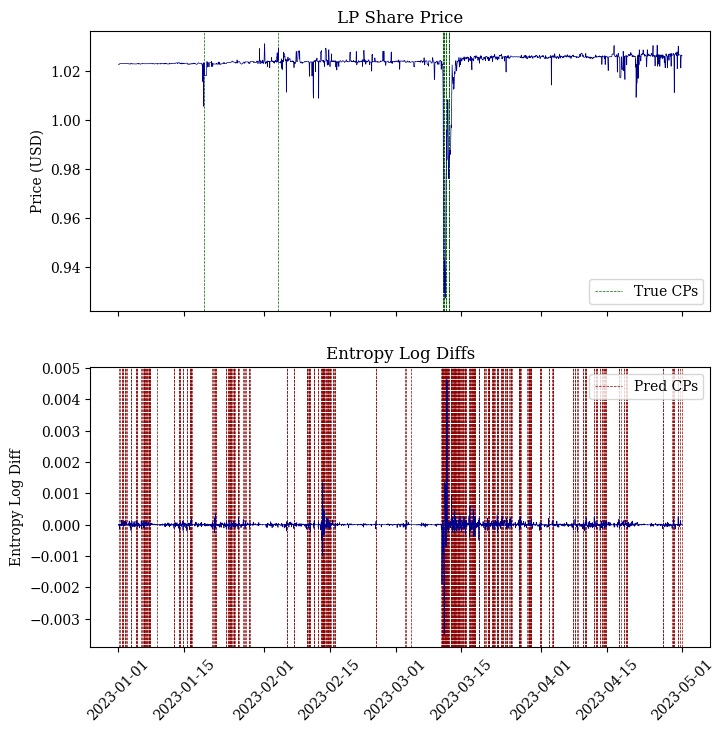

In [96]:
a, b, k = bocd.best_params
bocd.update({'alpha': a, 'beta': b, 'kappa': k})
pred = bocd.predict(X)
bocd_plot_comp(X, port, y.index, pred)

(0.1515151515151515, 1.0, 0.125)


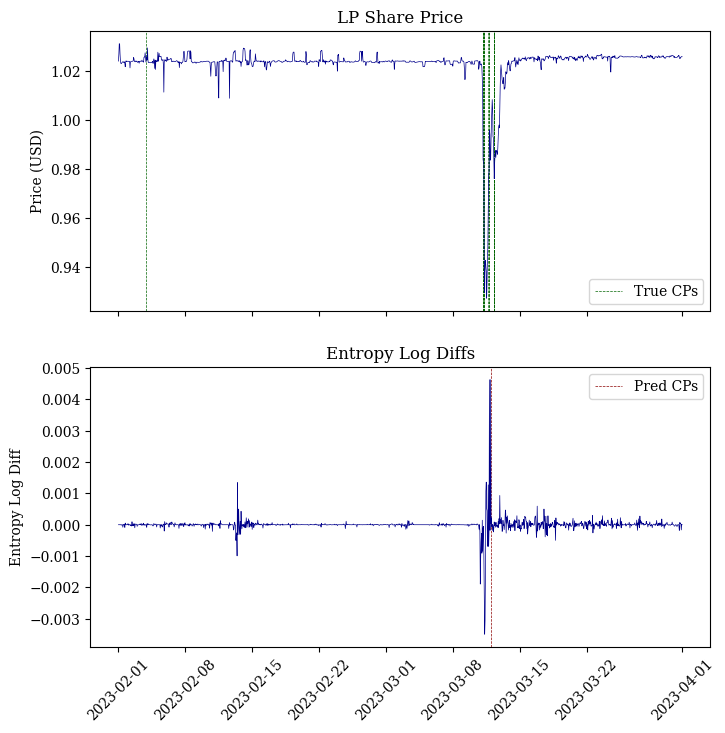

In [ ]:
a, b, k = max(results, key=lambda x: results[x][1])
print(results[(a, b, k)])
pred = predict(metric, {'lambda': 100, 'alpha': a, 'beta': b, 'kappa': k, 'mu': 0})
bocd_plot_comp(metric, port, cps, pred)

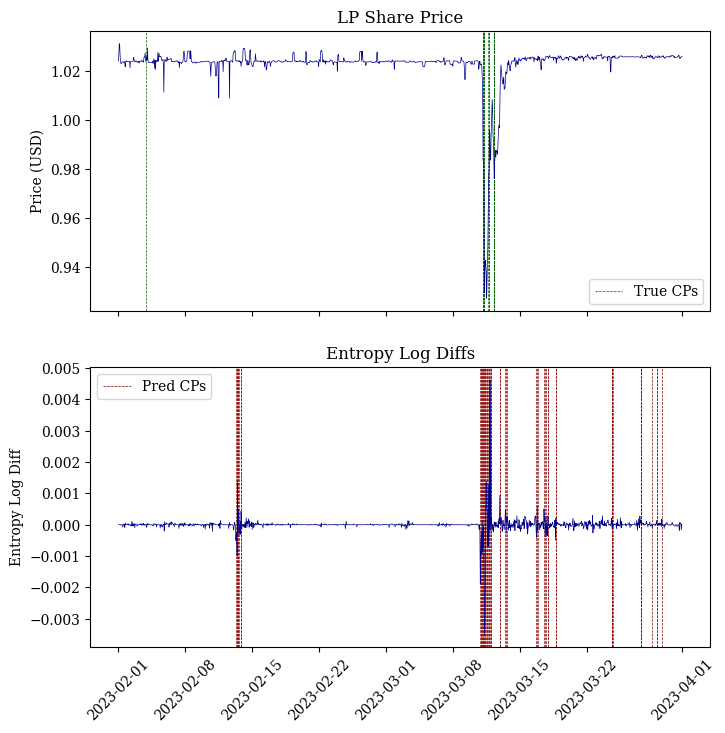

: 

In [ ]:
a, b, k = max(results, key=lambda x: results[x][2])
R, maxes = bocd(metric[:-1], alpha=a, beta=b, kappa=k)
peaks = np.where(maxes[:-1]!=maxes[1:]-1)[0][:-1]
bocd_plot_comp(metric, port, cps, peaks)